In [1]:
import seaborn as sns
import pandas as pd
import re
from matplotlib import pyplot as plt
import glob

In [174]:
csv_files = glob.glob("output_runs/*.output.csv")
data = pd.DataFrame({})

for csv_file in csv_files:
    tmp_df = pd.read_csv(csv_file,delimiter=",")

    data = pd.concat([data,tmp_df],ignore_index=True)
data['IO_perf'] = data['IO_perf'].str.split(' ', n=3, expand=True)[2].astype("float")
data['block_size'] = data['block_size'].str.split(r'\D', n=0, expand=True)[0].astype("float")
data['transfer_size'] = data['transfer_size'].str.split(r'\D', n=0, expand=True)[0].astype("float")

data.loc[data['block_size'] == 256.0, 'block_size'] = 0.256
data.loc[data['block_size'] == 512.0, 'block_size'] = 0.512


data['transfer_size'] = data['transfer_size']/1000 # All transfersize is in MB. Convert to GB

data['nodes'] = data['ntasks']/data['ntasks_per_node']


# by changing the blockSize in IOR to adjust file size, 
# file size = blockSize * numTasks * segmentCount
# one segment used
# the transferSize is fixed at 2MB and there is only

data['filesize(GB)'] = data['block_size'] * data['ntasks']
data = data.sort_values(by='partition')

/var/folders/11/xrwdlwlj4_nbhvdpknpy_ykr0000gp/T/ipykernel_24958/4243570403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['IO_perf'] = plot_data['IO_perf']/1000
/var/folders/11/xrwdlwlj4_nbhvdpknpy_ykr0000gp/T/ipykernel_24958/4243570403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['IO_perf'] = plot_data['IO_perf']/1000
/var/folders/11/xrwdlwlj4_nbhvdpknpy_ykr0000gp/T/ipykernel_24958/4243570403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

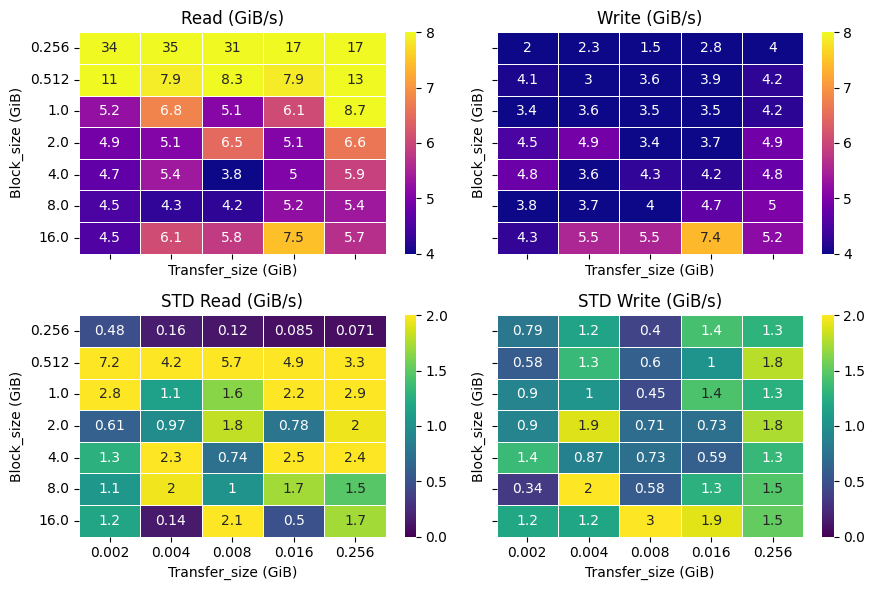

In [175]:
for partition in data['partition'].unique():

    plt.close()
    
    plot_data = data[(data['partition'] == partition) & (data['ntasks'] == 8) & (data['nodes'] == 1)]
    plot_data['IO_perf'] = plot_data['IO_perf']/1000
    
    read_data = plot_data[plot_data['IO_type'] == "read"]
    write_data = plot_data[plot_data['IO_type'] == "write"]
    

    heat_readdata_mean = (
        read_data.pivot_table(index="block_size", columns="transfer_size", values="IO_perf",aggfunc='mean')
    )
    
    heat_writedata_mean = (
        write_data.pivot_table(index="block_size", columns="transfer_size", values="IO_perf",aggfunc='mean')
    )
    
    heat_readdata_std = (
        read_data.pivot_table(index="block_size", columns="transfer_size", values="IO_perf",aggfunc='std')
    )
    
    heat_writedata_std = (
        write_data.pivot_table(index="block_size", columns="transfer_size", values="IO_perf",aggfunc='std')
    )
    
    f, axs = plt.subplots(figsize=(9, 6),ncols=2,nrows=2,sharey=True,sharex=True)
    
    sns.heatmap(heat_readdata_mean,  annot=True, cmap="plasma",linewidths=.5, ax=axs[0,0],vmin=4,vmax=8)
    sns.heatmap(heat_writedata_mean, annot=True, cmap="plasma",linewidths=.5, ax=axs[0,1],vmin=4,vmax=8)

    sns.heatmap(heat_readdata_std,  annot=True, cmap="viridis",linewidths=.5, ax=axs[1,0],vmin=0,vmax=2)
    sns.heatmap(heat_writedata_std, annot=True, cmap="viridis",linewidths=.5, ax=axs[1,1],vmin=0,vmax=2)
    
    axs[0,0].set_title("Read (GiB/s)")
    axs[0,1].set_title("Write (GiB/s)")

    axs[1,0].set_title("STD Read (GiB/s)")
    axs[1,1].set_title("STD Write (GiB/s)")
    
    axs[0,0].set_ylabel("Block_size (GiB)")
    axs[0,1].set_ylabel("Block_size (GiB)")
    axs[1,0].set_ylabel("Block_size (GiB)")
    axs[1,1].set_ylabel("Block_size (GiB)")
    
    axs[0,0].set_xlabel("Transfer_size (GiB)")
    axs[0,1].set_xlabel("Transfer_size (GiB)")
    axs[1,0].set_xlabel("Transfer_size (GiB)")
    axs[1,1].set_xlabel("Transfer_size (GiB)")

    plt.tight_layout()
    plt.savefig("plots/" + partition + "_heatmap_blockvtransfer.png",dpi=200)


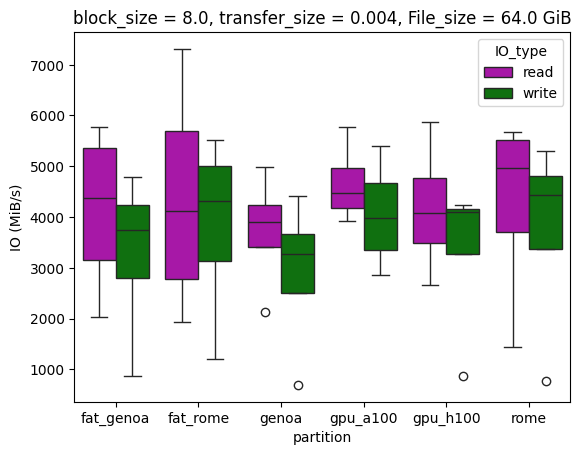

In [178]:
plot_data = data[(data['transfer_size'] == 0.004) & (data['block_size'] == 8.0) & (data['ntasks'] == 8) & (data['nodes'] == 1)].sort_values(['IO_type','partition'])
plt.close()

sns.boxplot(x="partition", y="IO_perf",
            hue="IO_type", palette=["m", "g"],
            data=plot_data)
plt.title("block_size = " +str(plot_data['block_size'].unique()[0])+", transfer_size = " +str(plot_data['transfer_size'].unique()[0])+", File_size = " + str(plot_data['filesize(GB)'].unique()[0]) + ' GiB')
plt.ylabel("IO (MiB/s)")
plt.savefig("plots/all_nodes_bs8GiB_ts4MiB_FS_64GiB_1node_8ppn.png",dpi=200)
plt.show()

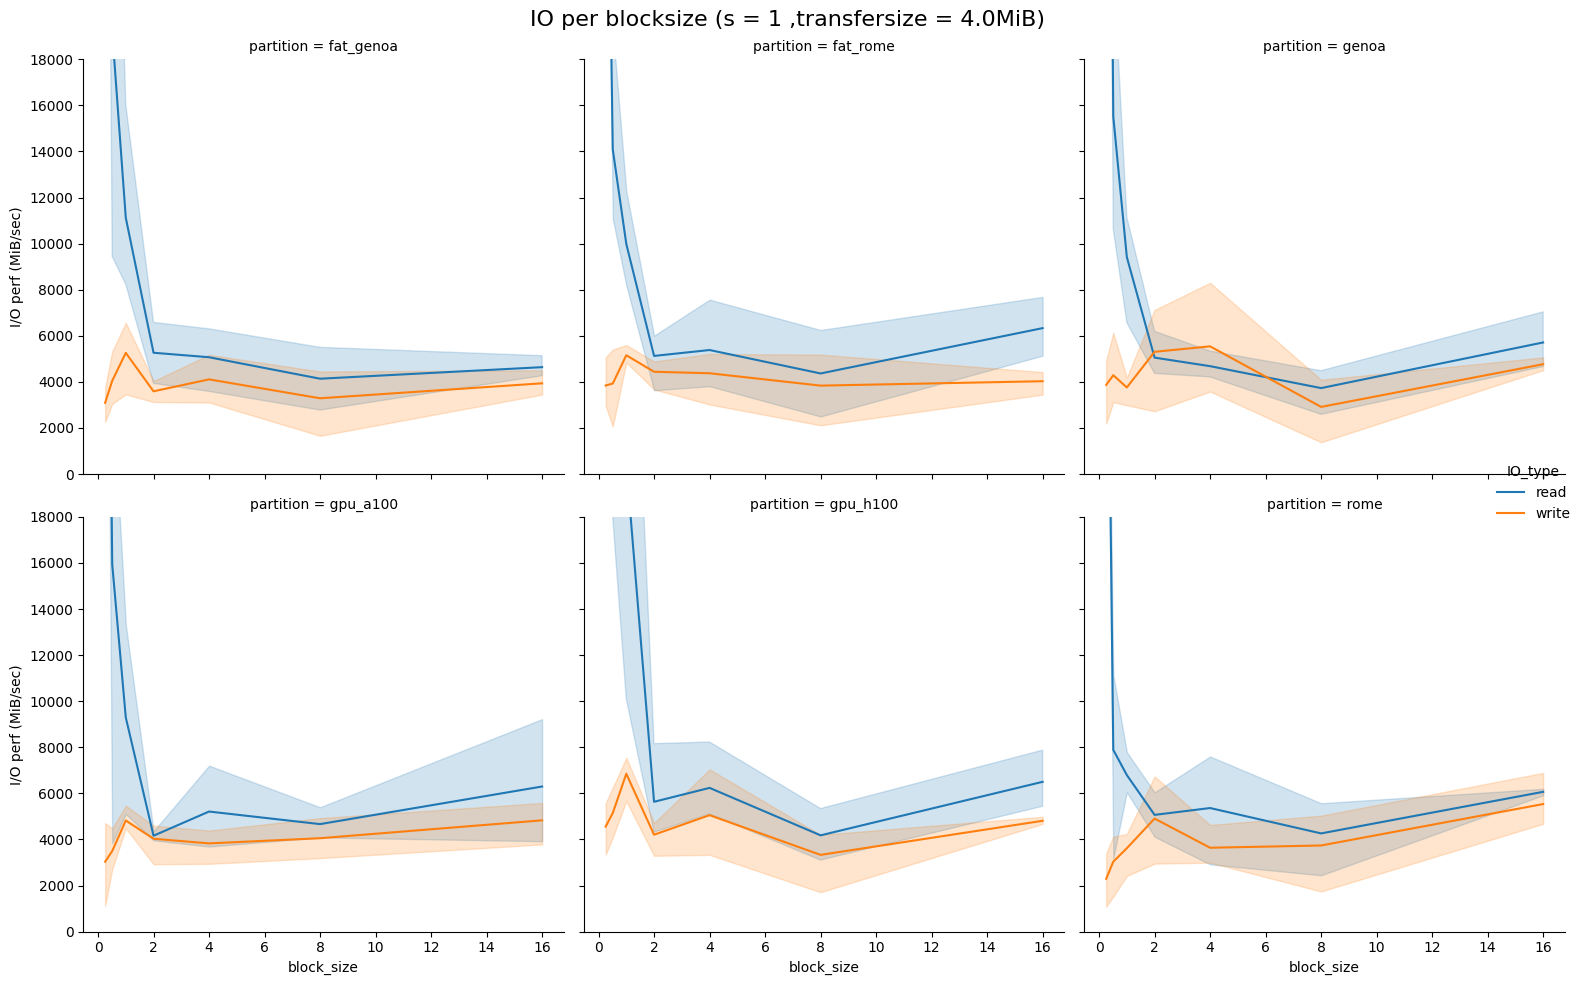

In [179]:
plt.close()
transfer_size = 0.004
plot_data = data[(data['transfer_size'] == transfer_size) & (data['ntasks'] == 8) & (data['nodes'] == 1)]

ben = sns.relplot(data=plot_data,x="block_size", y="IO_perf", col="partition", kind='line', hue="IO_type", col_wrap=3)
ben.set_ylabels("I/O perf (MiB/sec)", clear_inner=False)
plt.ylim(0,18000)
ben.fig.suptitle("IO per blocksize (s = 1 ,transfersize = "+ str(transfer_size*1000) +"MiB)", fontsize=16)
plt.tight_layout()
plt.savefig("IO_per_blocksize_segment1_transfersize"+str(transfer_size*1000)+"M.png",dpi=200)
plt.show()

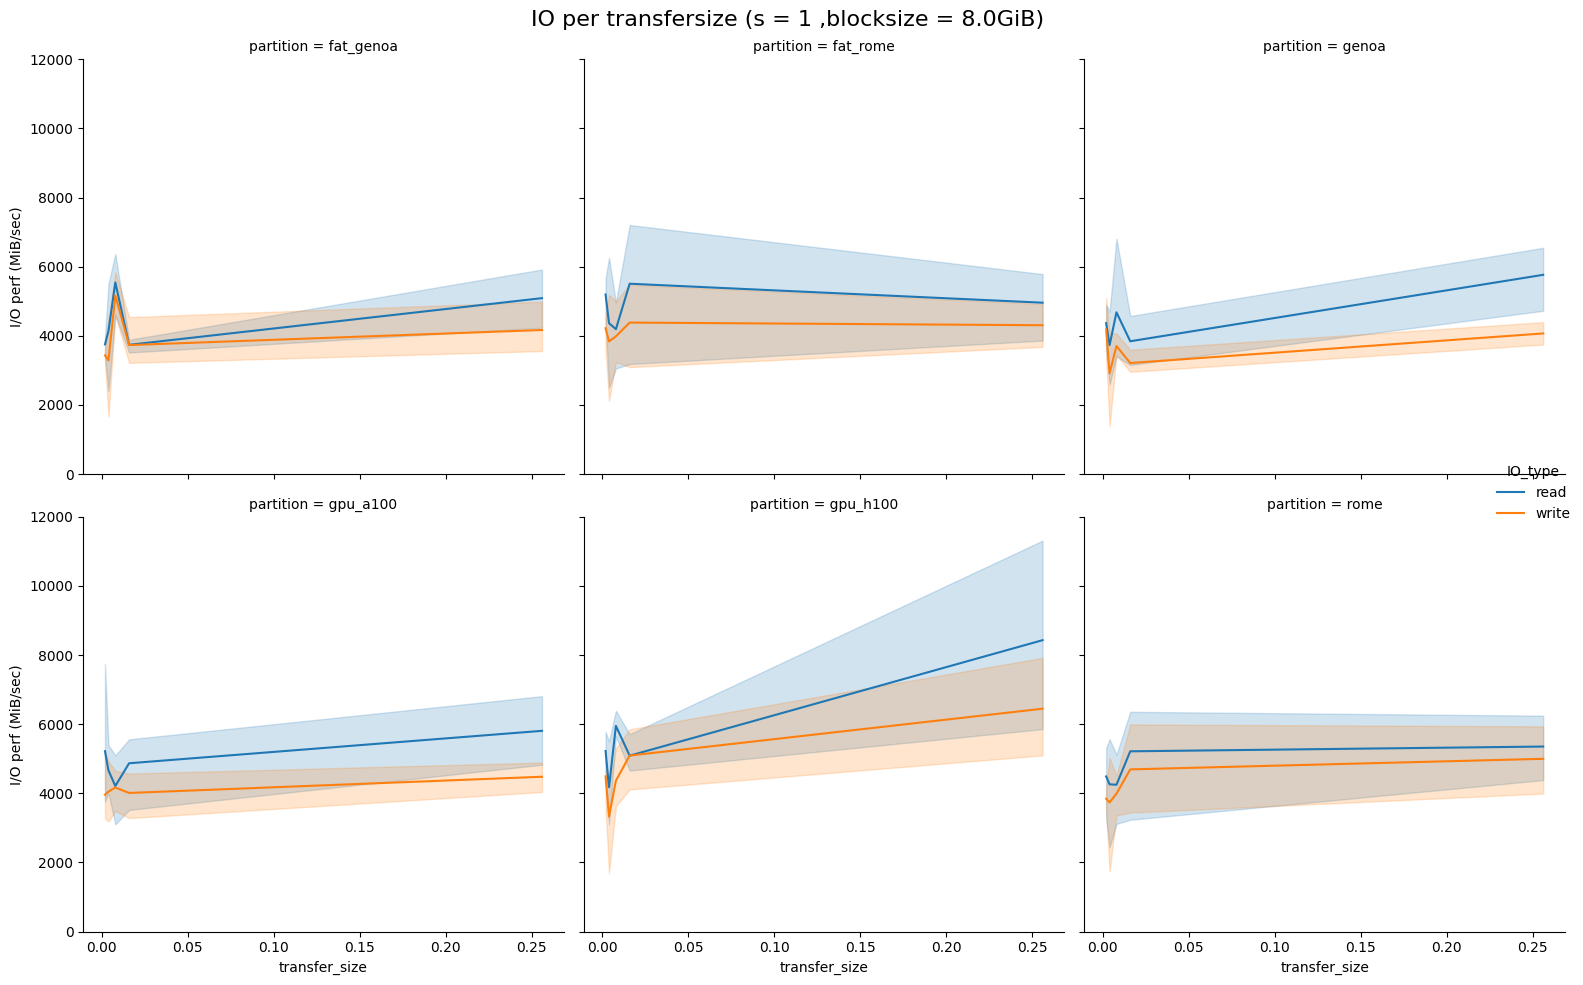

In [180]:
plt.close()
block_size = 8.0
plot_data = data[(data['block_size'] == block_size) & (data['ntasks'] == 8) & (data['nodes'] == 1)]

ben = sns.relplot(data=plot_data,x="transfer_size", y="IO_perf", col="partition", kind='line', hue="IO_type", col_wrap=3)
ben.set_ylabels("I/O perf (MiB/sec)", clear_inner=False)
plt.ylim(0,12000)
ben.fig.suptitle("IO per transfersize (s = 1 ,blocksize = "+ str(block_size) +"GiB)", fontsize=16)
plt.tight_layout()
plt.savefig("IO_per_transfersize_segment1_blocksize"+str(block_size)+"G.png",dpi=200)
plt.show()

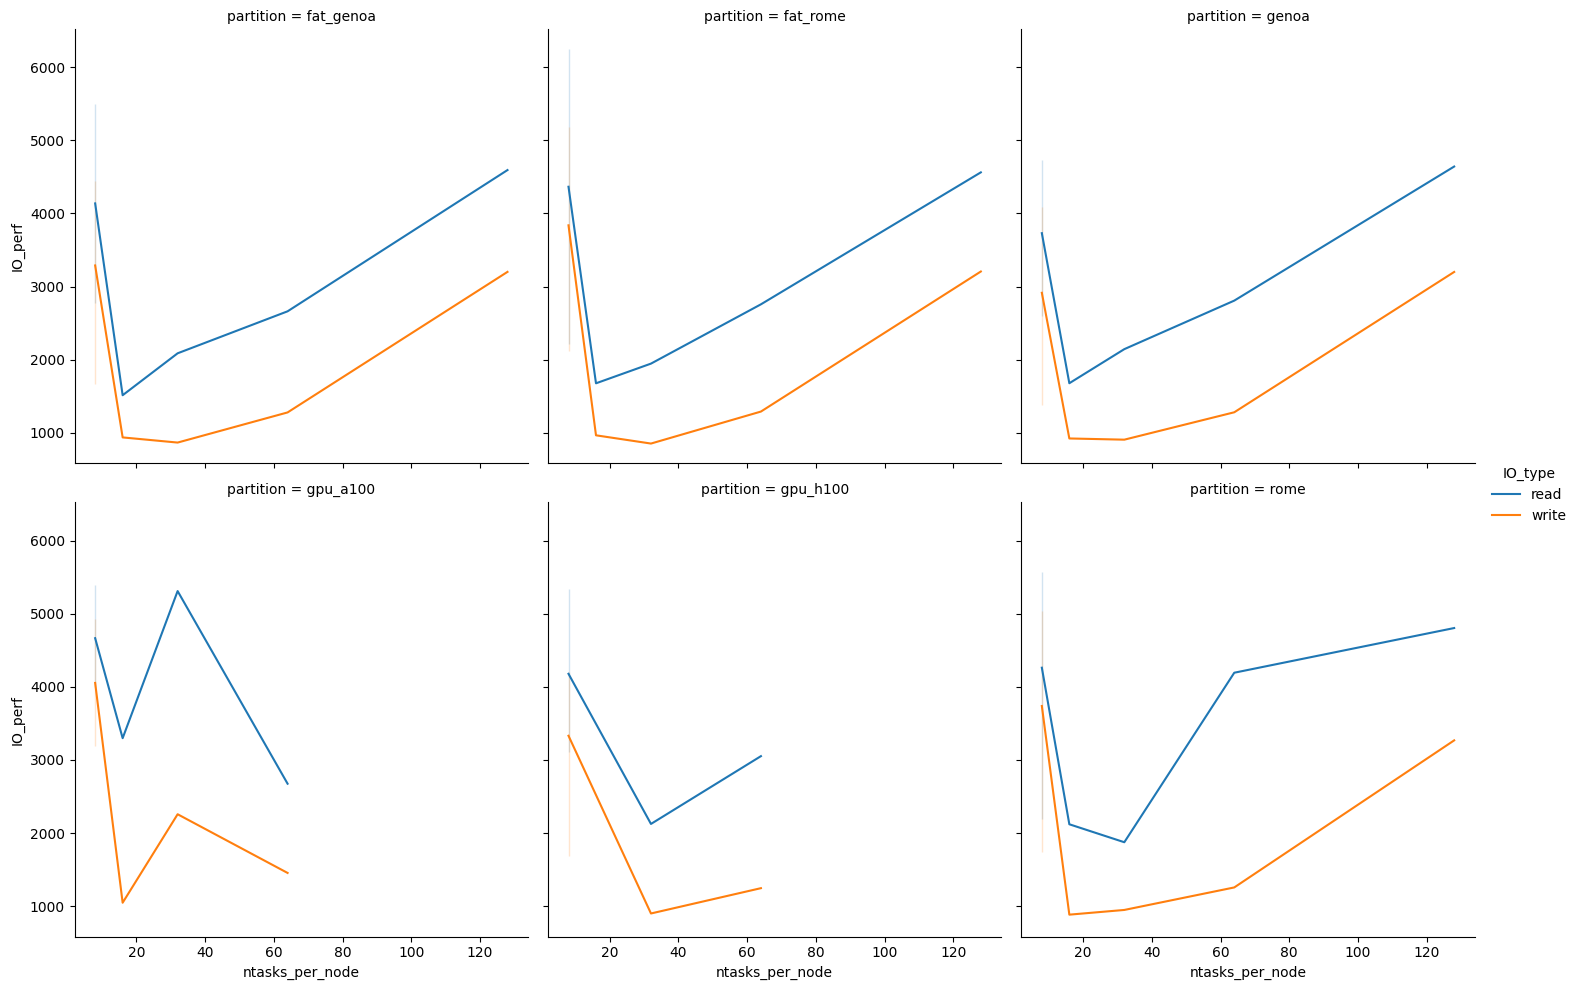

In [181]:
plt.close()
block_size = 8.0
transfer_size = 0.004
plot_data = data[(data['transfer_size'] == transfer_size) & (data['block_size'] == block_size) & (data['nodes'] == 1.0)].sort_values(['IO_type','partition'])
ben = sns.relplot(data=plot_data,x="ntasks_per_node", y="IO_perf", col="partition", kind='line', hue="IO_type", col_wrap=3)
plt.savefig("plots/IO_ntasks_per_node_1node_ts" +str(transfer_size*1000)+ "MiB_" + str(block_size) + "GiB.png",dpi=200)
plt.show()

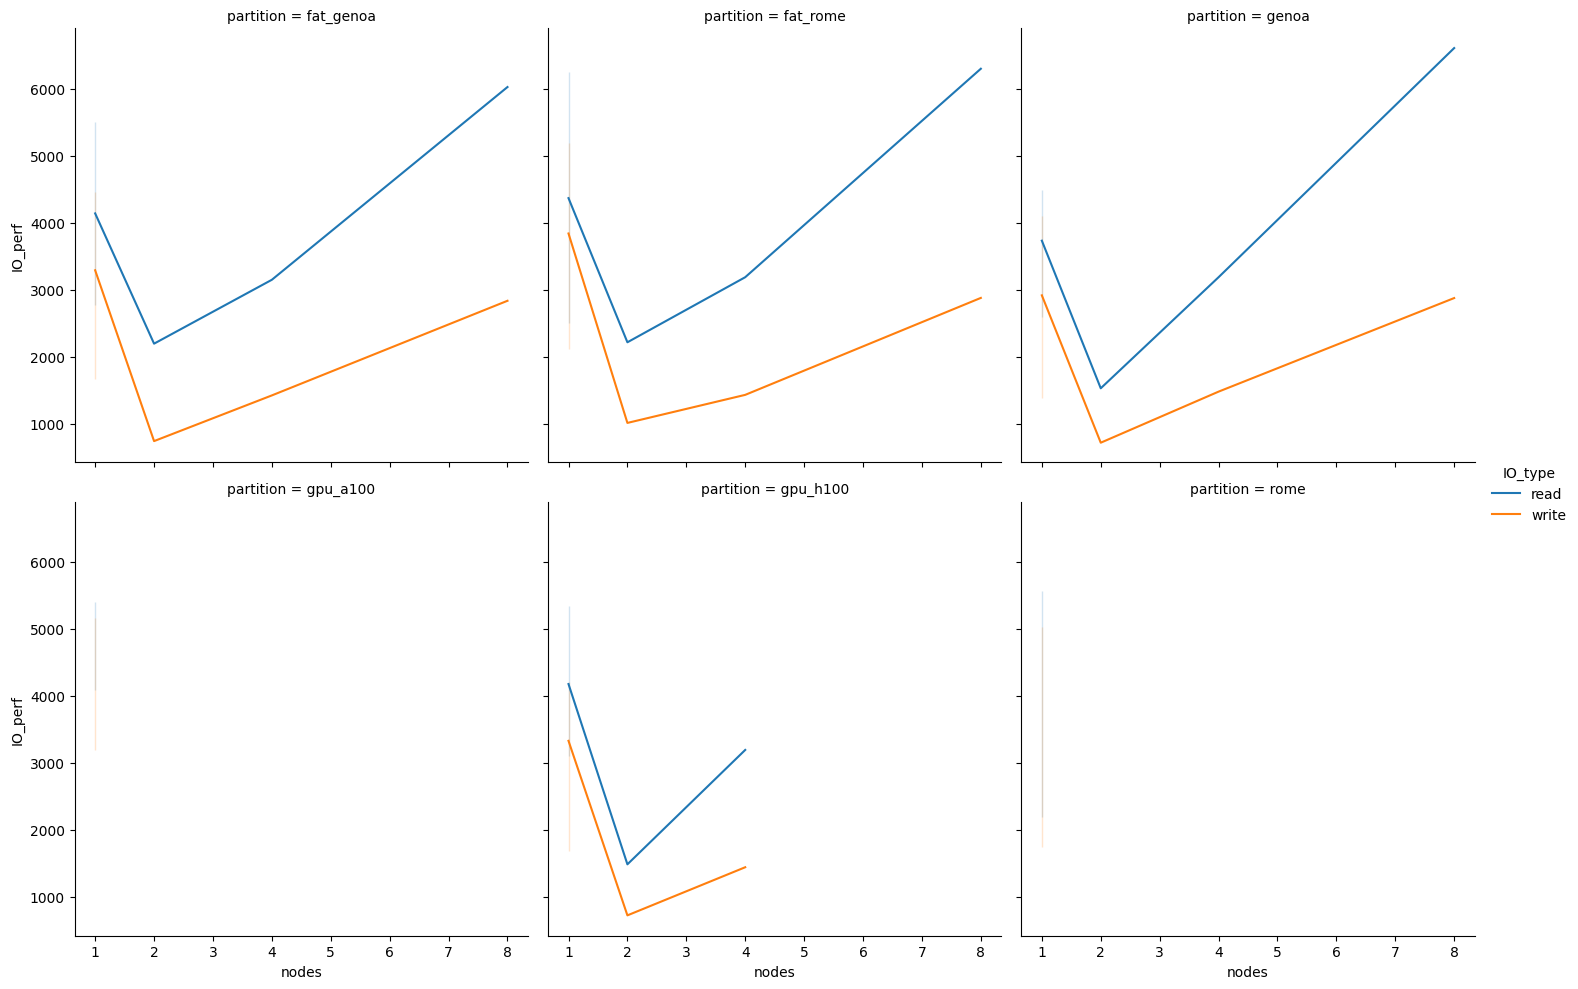

In [182]:
plt.close()
block_size = 8.0
transfer_size = 0.004
plot_data = data[(data['transfer_size'] == transfer_size) & (data['block_size'] == block_size) & (data['ntasks_per_node'] == 8.0)].sort_values(['IO_type','partition'])
ben = sns.relplot(data=plot_data,x="nodes", y="IO_perf", col="partition", kind='line', hue="IO_type", col_wrap=3)
plt.savefig("plots/IO_per_node_8ppn_ts" +str(transfer_size*1000)+ "MiB_" + str(block_size) + "GiB.png",dpi=200)
plt.show()

In [ ]:
partitions= ["genoa", "rome", "fat_genoa", "fat_rome", "gpu_a100", "gpu_h100"]
toolchain="foss_2023"
nodes="1"
procs_per_node="8"
block_sizes = [ "256m", "512m", "1g", "2g", "4g", "8g" ,"16g"]


#

data = pd.DataFrame(columns=["Partition", "toolchain", "nodes", "procs_per_node", "block_size(GB)", "I/O(MiB/sec)", "I/O_Type" ])

for partition in partitions:
    for block_size in block_sizes:

        file = partition + "." + toolchain + ".N" + nodes + "_ppn" + procs_per_node + "." + block_size +".output"

        if "m" in block_size:
            block_size = float(block_size.strip("m"))/1000
        elif "g" in block_size:
            block_size = float(block_size.strip("g"))

        for IO_type in ["Read", "Write"]:

            pattern = re.compile("Max "+IO_type+":\W*[+-]?(?P<number>(\d+\.\d*)|(\.\d+)|(\d+))([eE][+-]?\d+)?")

            tmp_df = pd.DataFrame({    
            "Partition": [partition],
            "toolchain": [toolchain],
            "nodes": [nodes],
            "procs_per_node": [procs_per_node],
            "block_size(GB)": [block_size],
            "I/O_Type": [IO_type],
            })
        
            for i, line in enumerate(open("output_runs/" + file)):
                for match in re.finditer(pattern, line):
                    tmp_df["I/O(MiB/sec)"] = match.groupdict()['number']
    
            data = pd.concat([data,tmp_df],ignore_index=True)
            
data['I/O(MiB/sec)'] = data['I/O(MiB/sec)'].astype('float64') 
data['nodes'] = data['nodes'].astype('float64') 
data['procs_per_node'] = data['procs_per_node'].astype('float64') 

# by changing the blockSize in IOR to adjust file size, 
# file size = blockSize * numTasks * segmentCount
# one segment used
# the transferSize is fixed at 2MB and there is only


data['filesize(GB)'] = data['block_size(GB)'] * data['procs_per_node'] * data['nodes']
